# Human Similarity & Word Embeddings Analysis
This notebook explores the relationship between human similarity judgments and word embeddings (GloVe).  

**Goal:** Understand how well embeddings capture human cognitive relatedness.


Core Concepts :
1) Similarity: how much two concepts share in meaning or category (e.g., dog and wolf).

2) Association: how frequently or contextually two concepts occur together (e.g., dog and bone).

3) Relatedness: the actual cognitive state representing how the brain internally connects two concepts — integrating both similarity and association.


In [15]:
# All required libraries
import pandas as pd
import numpy as np
import gensim.downloader as api
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors
from numpy import nan

1) Loading of Glove embedding vectors of 50,100,200 and 300 dimensions

In [ ]:

model_gen_300 = api.load("glove-wiki-gigaword-300")
model_gen_300.save("glove_wiki_300.model")
model_gen_300 = KeyedVectors.load("glove_wiki_300.model", mmap='r')


In [3]:
model_gen_200 = api.load("glove-wiki-gigaword-200")
model_gen_200.save("glove_wiki_200.model")
model_gen_200 = KeyedVectors.load("glove_wiki_200.model", mmap='r')

In [4]:
model_gen_100 = api.load("glove-wiki-gigaword-100")
model_gen_100.save("glove_wiki_100.model")
model_gen_100 = KeyedVectors.load("glove_wiki_100.model", mmap='r')

In [5]:
model_gen_50 = api.load("glove-wiki-gigaword-50")
model_gen_50.save("glove_wiki_50.model")
model_gen_50 = KeyedVectors.load("glove_wiki_50.model", mmap='r')

2) Loading and preprocessing SimLex-999 dataset

In [13]:
import pandas as pd
df = pd.read_csv("SimLex-999 (1).csv")
df

,word1\tword2\tPOS\tSimLex999\tconc(w1)\tconc(w2)\tconcQ\tAssoc(USF)\tSimAssoc333\tSD(SimLex)
0,old\tnew\tA\t1.58\t2.72\t2.81\t2\t7.25\t1\t0.41
1,smart\tintelligent\tA\t9.2\t1.75\t2.46\t1\t7.1...
2,hard\tdifficult\tA\t8.77\t3.76\t2.21\t2\t5.94\...
3,happy\tcheerful\tA\t9.55\t2.56\t2.34\t1\t5.85\...
4,hard\teasy\tA\t0.95\t3.76\t2.07\t2\t5.82\t1\t0.93
...,...
994,join\tacquire\tV\t2.85\t2.86\t2.93\t2\t0\t0\t0.99
995,send\tattend\tV\t1.67\t2.7\t3.17\t2\t0\t0\t1.44
996,gather\tattend\tV\t4.8\t2.75\t3.17\t2\t0\t0\t1.97
997,absorb\twithdraw\tV\t2.97\t3.11\t3.04\t2\t0\t0...


In [ ]:
df_simlex = df.iloc[:,0].str.split("\t",expand=True)
str = "word1\tword2\tPOS\tSimLex999\tconc(w1)\tconc(w2)\tconcQ\tAssoc(USF)\tSimAssoc333\tSD(SimLex)"
features = str.split("\t")
df_simlex.columns = features
df_simlex["SimLex999"] = df_simlex["SimLex999"].astype(float)
df_simlex["Assoc(USF)"] = df_simlex["Assoc(USF)"].astype(float)
df_simlex.dtypes

word1           object
word2           object
POS             object
SimLex999      float64
conc(w1)        object
conc(w2)        object
concQ           object
Assoc(USF)     float64
SimAssoc333     object
SD(SimLex)      object
dtype: object

3) Calculating cosine similarity for each dimension

In [16]:
def get_cosine_similarity_300(w1,w2):
    try:
        return model_gen_300.similarity(w1,w2)
    except KeyError:
        return nan
df_simlex["cosine_similarity_glove_300"] = df_simlex.apply(lambda row:get_cosine_similarity_300(row["word1"],row["word2"]),axis=1)

In [17]:
def get_cosine_similarity_200(w1,w2):
    try:
        return model_gen_200.similarity(w1,w2)
    except KeyError:
        return nan
df_simlex["cosine_similarity_glove_200"] = df_simlex.apply(lambda row:get_cosine_similarity_200(row["word1"],row["word2"]),axis=1)

In [18]:
def get_cosine_similarity_100(w1,w2):
    try:
        return model_gen_100.similarity(w1,w2)
    except KeyError:
        return nan
df_simlex["cosine_similarity_glove_100"] = df_simlex.apply(lambda row:get_cosine_similarity_100(row["word1"],row["word2"]),axis=1)

In [19]:
def get_cosine_similarity_50(w1,w2):
    try:
        return model_gen_50.similarity(w1,w2)
    except KeyError:
        return nan
df_simlex["cosine_similarity_glove_50"] = df_simlex.apply(lambda row:get_cosine_similarity_50(row["word1"],row["word2"]),axis=1)

In [20]:
df_simlex

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex),cosine_similarity_glove_300,cosine_similarity_glove_200,cosine_similarity_glove_100,cosine_similarity_glove_50
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41,0.367693,0.488139,0.643249,0.619720
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67,0.652035,0.686475,0.755273,0.776587
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19,0.635781,0.689131,0.785255,0.816842
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18,0.440317,0.482753,0.545994,0.575719
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93,0.578426,0.666609,0.766768,0.860352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,join,acquire,V,2.85,2.86,2.93,2,0.00,0,0.99,0.285346,0.367084,0.464711,0.516720
995,send,attend,V,1.67,2.7,3.17,2,0.00,0,1.44,0.341219,0.423896,0.500936,0.561737
996,gather,attend,V,4.80,2.75,3.17,2,0.00,0,1.97,0.406434,0.482446,0.540244,0.625338
997,absorb,withdraw,V,2.97,3.11,3.04,2,0.00,0,1.75,0.155071,0.219240,0.289158,0.348489


4) Calculating correlation between human similarity that is SimLex-999 and cosine similarity for each dimension

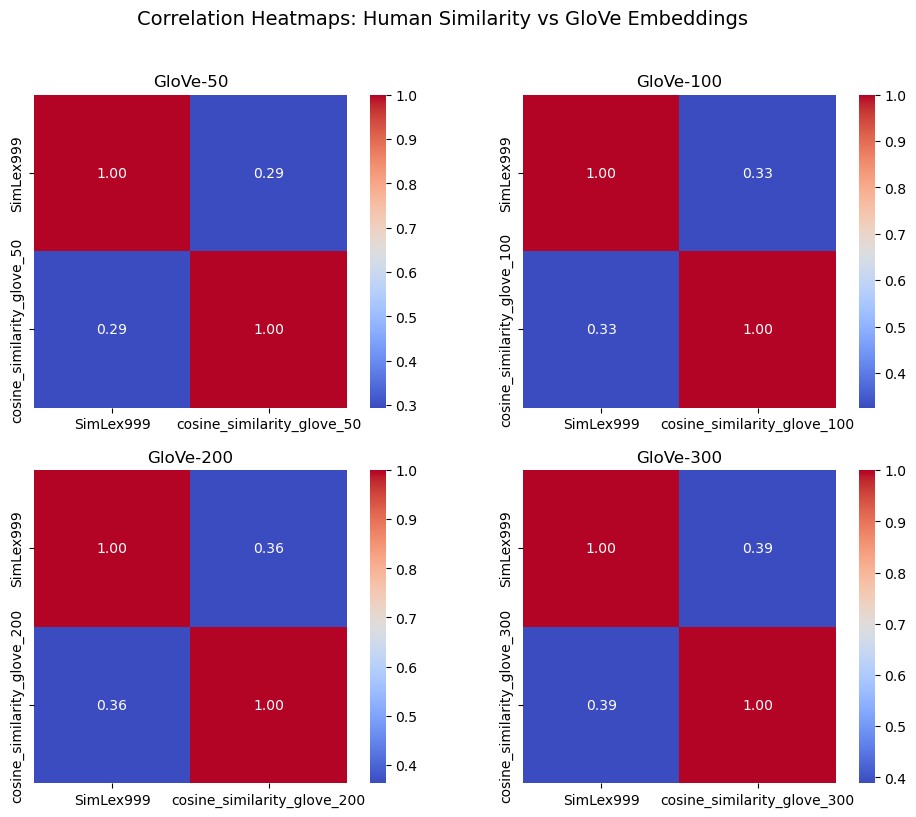

In [21]:

Dimensions = [50, 100, 200, 300]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, dim in zip(axes.flat, Dimensions):
    cm_df = df_simlex[["SimLex999", f"cosine_similarity_glove_{dim}"]]
    corr_cm = cm_df.corr()
    sns.heatmap(corr_cm, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=ax)
    ax.set_title(f"GloVe-{dim}", fontsize=12)

plt.suptitle("Correlation Heatmaps: Human Similarity vs GloVe Embeddings", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Insights : The correlation value increases as we increase the dimensions what it suggests is that additional dimensions captures more feactures about words but the correlation is significantly less from our objective

5) How well word embedding explains human similarity ?

In [22]:
model = LinearRegression()
r2_simlex = []
Dimensions = [50,100,200,300]
for dim in Dimensions:
 X = df_simlex[["SimLex999"]]
 y = df_simlex[f"cosine_similarity_glove_{dim}"]
 X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
 model.fit(X_train,y_train)
 y_pred = model.predict(X_test)
 r2 = r2_score(y_test,y_pred)
 r2 = round(r2, 5) 
 r2_simlex.append(r2)
r2_simlex 

[0.05174, 0.07753, 0.101, 0.12494]

Insight : Again the r2_score is significantly less as correlation

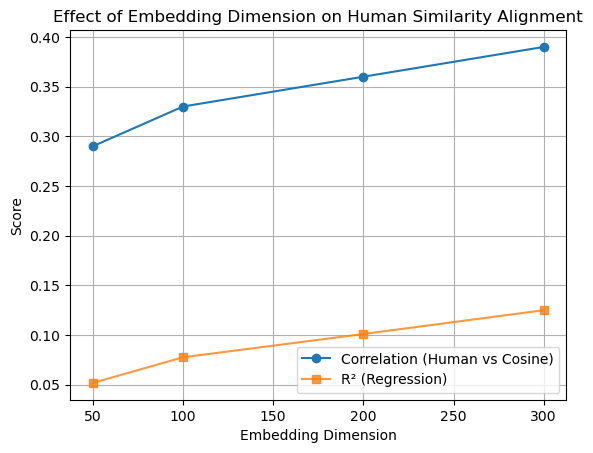

In [ ]:
dims = [50,100, 200, 300]
correlations = [0.29, 0.33, 0.36,0.39]

plt.plot(dims, correlations, 'o-', label='Correlation (Human vs Cosine)')
plt.plot(dims, r2_simlex, 's-', label='R² (Regression)', alpha=0.8)
plt.xlabel("Embedding Dimension")
plt.ylabel("Score")
plt.title("Effect of Embedding Dimension on Human Similarity Alignment")
plt.legend()
plt.grid(True)
plt.show()

Insight : This is important.The behaviour of correlation and r2_score is same as we increase the dimension of Glove word embedding

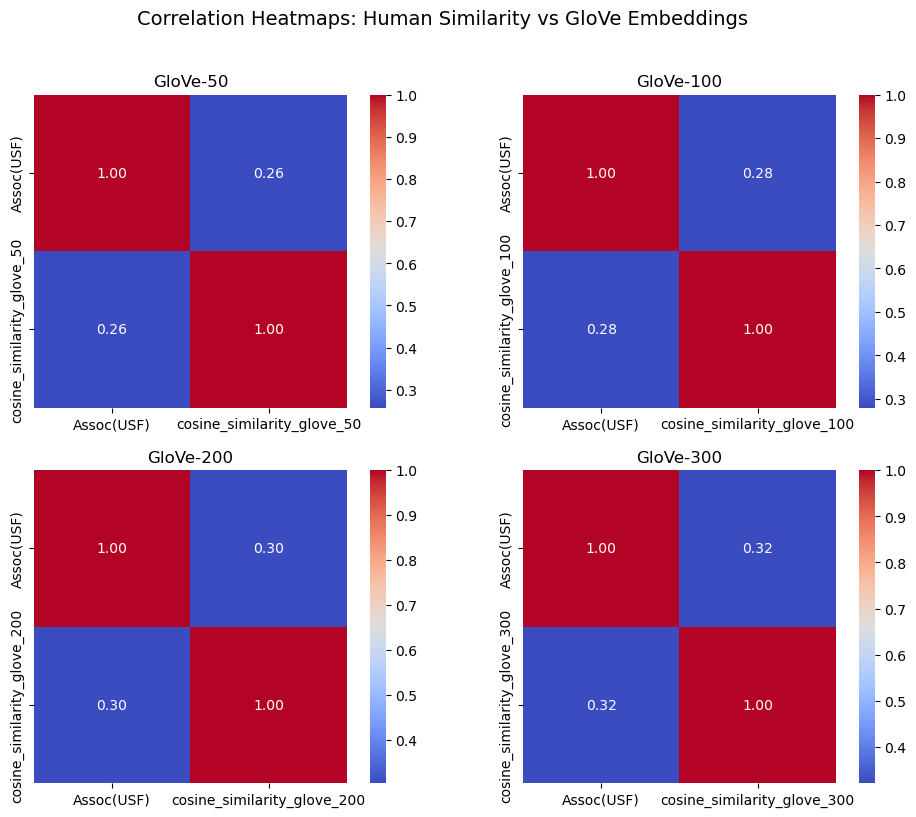

In [ ]:
Dimensions = [50, 100, 200, 300]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, dim in zip(axes.flat, Dimensions):
    cm_df = df_simlex[["Assoc(USF)", f"cosine_similarity_glove_{dim}"]]
    corr_cm = cm_df.corr()
    
    sns.heatmap(corr_cm, annot=True, cmap='coolwarm', fmt=".2f", square=True, ax=ax)
    ax.set_title(f"GloVe-{dim}", fontsize=12)

plt.suptitle("Correlation Heatmaps: Human Similarity vs GloVe Embeddings", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Interpretation (SimLex-999):

The correlation between cosine similarity (from GloVe embeddings) and human-judged similarity gradually increases with dimensionality, but remains modest.

Even at 300D, the R² score reaches only ~0.125, suggesting that GloVe embeddings capture limited alignment with human similarity judgments.

The association-based correlations remain slightly lower than similarity-based ones, indicating that SimLex data reflects biased or constrained volunteer judgments rather than genuine cognitive relatedness.
That's why we need data set that reflects relatedness not just one of association or similarity

6) Data preprocessing of MEN's Dataset And the rest processes are same as earlier

In [58]:
df_men  =pd.read_csv("MEN_dataset_lemma_form_full",sep=" ",        
                 header=None,    
                 names=["word1","word2","human_score"])
df_men

,word1,word2,human_score
0,sun-n,sunlight-n,50.0
1,automobile-n,car-n,50.0
2,river-n,water-n,49.0
3,stair-n,staircase-n,49.0
4,morning-n,sunrise-n,49.0
...,...,...,...
2995,feather-n,truck-n,1.0
2996,festival-n,whisker-n,1.0
2997,muscle-n,tulip-n,1.0
2998,bikini-n,pizza-n,1.0


In [59]:
def get_pos(w1):
    return w1.split("-")[1]

df_men["word1_POS"] = df_men.apply(lambda row:get_pos(row["word1"]),axis=1)
df_men["word2_POS"] = df_men.apply(lambda row:get_pos(row["word2"]),axis=1)


In [60]:
df_men.word1_POS.unique()

array(['n', 'j', 'v'], dtype=object)

In [61]:
df_men1  =pd.read_csv("MEN_dataset_natural_form_full",sep=" ",        
                 header=None,    
                 names=["word1","word2","human_score"])
df_men1["word1_POS"] = df_men["word1_POS"]
df_men1["word2_POS"] = df_men["word2_POS"]
df_men1

,word1,word2,human_score,word1_POS,word2_POS
0,sun,sunlight,50.0,n,n
1,automobile,car,50.0,n,n
2,river,water,49.0,n,n
3,stairs,staircase,49.0,n,n
4,morning,sunrise,49.0,n,n
...,...,...,...,...,...
2995,feathers,truck,1.0,n,n
2996,festival,whiskers,1.0,n,n
2997,muscle,tulip,1.0,n,n
2998,bikini,pizza,1.0,n,n


In [67]:
df_men1["cosine_similarity_glove_300"] = df_men1.apply(lambda row:get_cosine_similarity_300(row["word1"],row["word2"]),axis=1)
df_men1["cosine_similarity_glove_200"] = df_men1.apply(lambda row:get_cosine_similarity_200(row["word1"],row["word2"]),axis=1)
df_men1["cosine_similarity_glove_100"] = df_men1.apply(lambda row:get_cosine_similarity_100(row["word1"],row["word2"]),axis=1)
df_men1["cosine_similarity_glove_50"] = df_men1.apply(lambda row:get_cosine_similarity_50(row["word1"],row["word2"]),axis=1)

In [68]:
df_men1

,word1,word2,human_score,word1_POS,word2_POS,cosine_similarity_glove_300,cosine_similarity_glove_200,cosine_similarity_glove_100,cosine_similarity_glove_50
0,sun,sunlight,50.0,n,n,0.453869,0.477078,0.538196,0.560537
1,automobile,car,50.0,n,n,0.595573,0.626510,0.683194,0.695622
2,river,water,49.0,n,n,0.498581,0.554530,0.630601,0.619145
3,stairs,staircase,49.0,n,n,0.738294,0.758074,0.783232,0.808293
4,morning,sunrise,49.0,n,n,0.308487,0.397910,0.486942,0.584068
...,...,...,...,...,...,...,...,...,...
2995,feathers,truck,1.0,n,n,-0.093473,-0.105163,-0.026077,0.002846
2996,festival,whiskers,1.0,n,n,0.008592,-0.050759,-0.065309,-0.153343
2997,muscle,tulip,1.0,n,n,-0.047514,-0.004835,0.134914,0.131196
2998,bikini,pizza,1.0,n,n,0.103595,0.150064,0.100336,0.104681


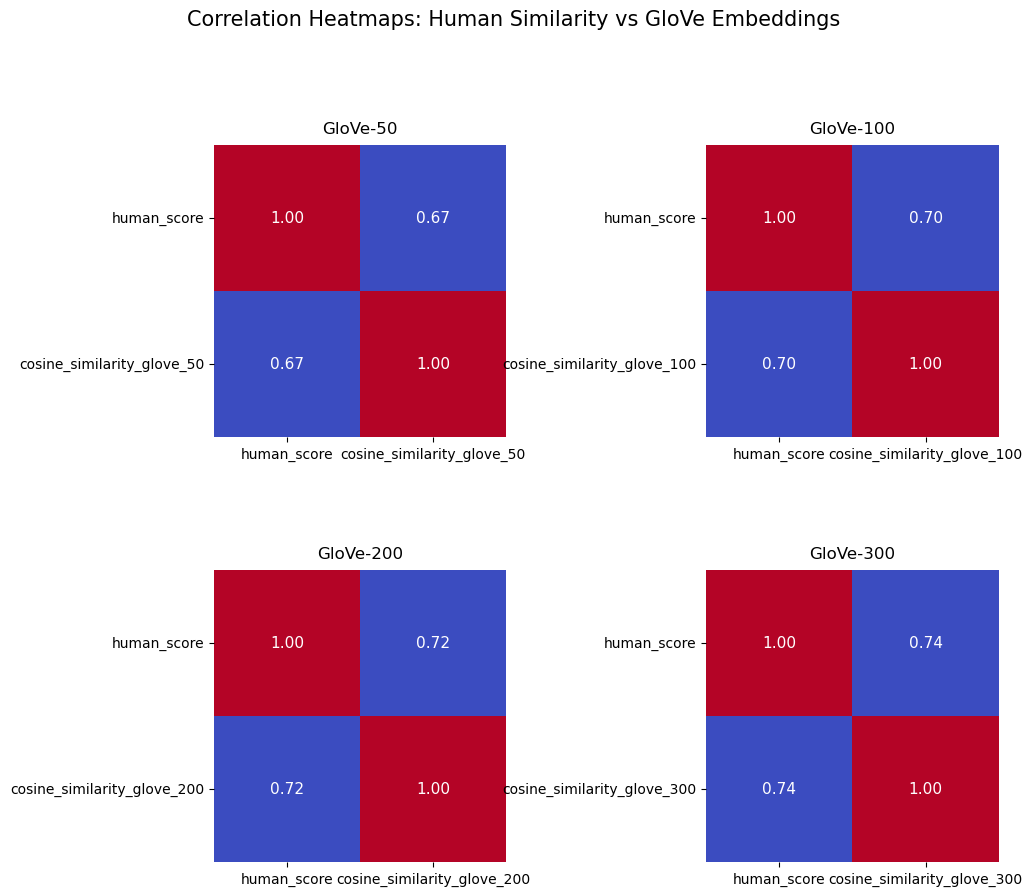

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
Dimensions = [50, 100, 200, 300]
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

for ax, dim in zip(axes.flat, Dimensions):
    cm_df = df_men1[["human_score", f"cosine_similarity_glove_{dim}"]]
    corr_cm = cm_df.corr()
    
    sns.heatmap(
        corr_cm,
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        square=True,
        ax=ax,
        cbar=False,  
        annot_kws={"size": 11}
    )

    ax.set_title(f"GloVe-{dim}", fontsize=12, pad=8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.suptitle("Correlation Heatmaps: Human Similarity vs GloVe Embeddings", fontsize=15, y=1.03)
plt.tight_layout()
plt.show()


In [ ]:
model = LinearRegression()
r2_men = []
Dimensions = [50,100,200,300]
for dim in Dimensions:
 X = df_men1[[f"cosine_similarity_glove_{dim}"]]
 y = df_men1["human_score"]
 X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
 model.fit(X_train,y_train)
 y_pred = model.predict(X_test)
 r2 = r2_score(y_test,y_pred)
 r2 = round(r2, 5) 
 r2_men.append(r2)

In [84]:
r2_men

[0.44586, 0.49412, 0.52206, 0.5537]

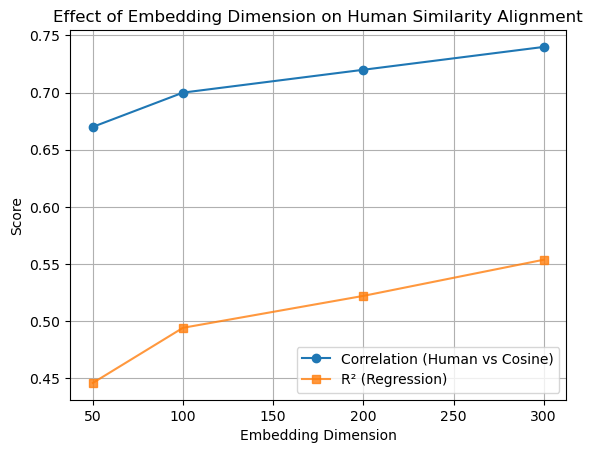

In [ ]:
dims = [50,100, 200, 300]
correlations = [0.67,0.70,0.72,0.74]

plt.plot(dims, correlations, 'o-', label='Correlation (Human vs Cosine)')
plt.plot(dims, r2_men, 's-', label='R² (Regression)', alpha=0.8)
plt.xlabel("Embedding Dimension")
plt.ylabel("Score")
plt.title("Effect of Embedding Dimension on Human Similarity Alignment")
plt.legend()
plt.grid(True)
plt.show()

Interpretation (MEN):

The MEN dataset shows stronger correlations and much higher R² values than SimLex-999.

Both metrics improve steadily as dimensionality increases, indicating that higher-dimensional embeddings capture richer cognitive relationships between words.

At 300D, correlation reaches 0.74 and R² 0.55, implying that about 55% of human-relatedness variance can be linearly predicted from cosine similarity.

This suggests that the MEN dataset better reflects how the human brain organizes and relates concepts — emphasizing contextual and associative similarity rather than pure categorical meaning.

Conclusions

1. Relatedness = f(Similarity, Association)

Human understanding of concepts arises from a blend of similarity and association.
Purely similarity-based or association-based measures (like in SimLex) fail to capture the full cognitive picture.
The MEN dataset, which implicitly includes both, aligns more closely with human judgments — indicating that relatedness is a composite cognitive function, not a single dimension.


2. Cognitive Geometry Is Higher-Dimensional (>300D)

The steady increase in both correlation and R² score with embedding dimensions (from 50D to 300D) suggests that human cognitive representation of meaning operates in a much higher-dimensional space.
Each dimension adds subtle relational cues — emotional, functional, contextual — that together approximate human-like semantic intuition.
This implies that the mental geometry of meaning is inherently complex, distributed, and multidimensional, exceeding the capacity of conventional low-dimensional embeddings.